In [85]:
import numpy as np
from scipy.stats import norm
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import datetime

from sklearn.linear_model import LinearRegression

### Dark theme pour matplotlib ###
from ing_theme_matplotlib import mpl_style

### Import du theme sombre pour matplotlib


In [86]:
mpl_style(dark=True)

In [87]:


X=np.array(
    [[5.,23.,34.,35,3],
    [22,71,0,3,0],
    [3,42,27,26,2],
    [1,7,31,59,2],
    [3,23,33,29,12],
    
    ]
)
X2=np.array(
    [[3.,21.,32.,39,5],
    [12,60,21,5,2],
    [3,42,24,28,3],
    [1,9,25,60,5],
    [2,21,34,28,15],
    ]
)
y=np.array([6.,28,29,31,6,4.,26,30,32,8])
X_all=np.concatenate((X.T,X2.T),axis=0)
lr = LinearRegression().fit(X_all, y)
print(np.dot(X_all,lr.coef_))
print(lr.coef_*1000)
lr.intercept_


X=np.array(
    [[10.,3.,2.,4,2],
    [24,26,25,22,33],
    [33,31,29,31,28],
    [19,27,37,35,32],
    [14,13,7,8,5],
    [11,5,5,6,4],
    [26,28,25,30,30],
    [35,37,27,26,27],
    [19,23,37,33,33],
    [9,7,6,5,4],
    ]
)
y=np.array([4.,26,30,32,8,6.,28,29,31,6])
lr = LinearRegression().fit(X, y)
# print(np.sum(X[:,0]*lr.coef_.T))
print(lr.coef_*1000)


[ 5.34734882 27.54798694 28.39977844 30.09763167  5.35240545  3.30612863
 25.25725284 29.25954606 31.70866098  7.60909243]
[364.03181672  98.8824073   97.30961153  86.85049071 324.33248316]
[144.69231815  89.3489229  261.25395915 269.38311787 234.62420026]


# Méthode pour le calcul des erreurs
Pour l'étude des variations il serait plus juste de définir la distance entre les deux courbes de répartition qui induirait un chance d'inversion des valeurs dans moins de 5% des cas.

0.049986

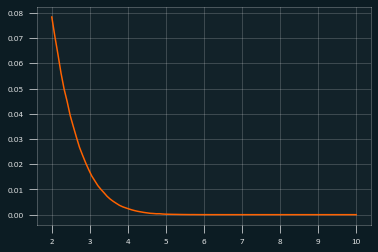

In [88]:
def sample_norm(mean1=0,std1=1,mean2=0,std2=1,size=1000000):
    a=np.random.normal(mean1, std1, size)
    b=np.random.normal(mean2, std2, size)
    return np.sum(a>b)/size

std=1
x = np.linspace(2, 10, 100)
y = [sample_norm(0,std,v,std,size=1000000) for v in x]
plt.plot(x,y)
sample_norm(0,std,std*2.328,std,size=1000000)

Une simulation monte carlo nous donne une valeur approximé à **2.328**. Il conviendrait d'utiliser cette valeur pour les études de variations. Das ce cas la marge d'erreur devrait être $$\frac{2.328}{2}\sigma=1.164\sigma$$

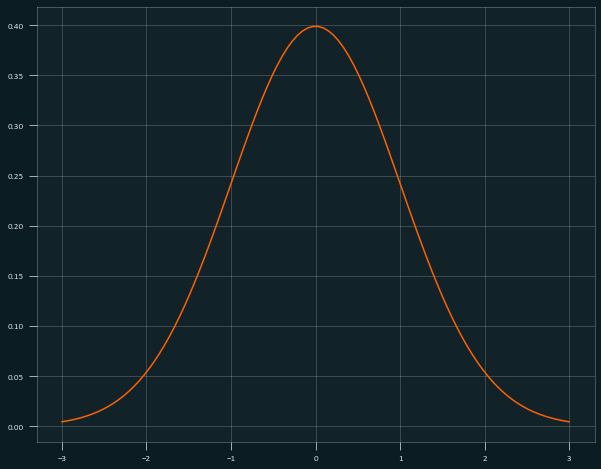

In [89]:
def draw_norm_err(m=0,std=1,err=0.95,xmin=0,xmax=7,draw_err=True):
    Za_min=norm.ppf(1-err,loc=m,scale=std)
    Za_max=norm.ppf(err,loc=m,scale=std)
    x = np.linspace(xmin, xmax, 100)
    y = norm.pdf(x,m,std)
    if draw_err:
        xerr = np.linspace(Za_min, Za_max, 100)
        yerr = norm.pdf(xerr,m,std)
        plt.fill_between(xerr, yerr,alpha=0.2)
    plt.plot(x,y)


plt.figure(figsize=(10,8))
xmin,xmax=0,7
std=1
m=2
err=0.95
# draw_norm_err(m,std,err,xmin,xmax)
# draw_norm_err(m+2,std,err,xmin,xmax)
draw_norm_err(0,std,err,-3,3,False)
# plt.savefig('loi_normale.png')


D:\Programmes\Python3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


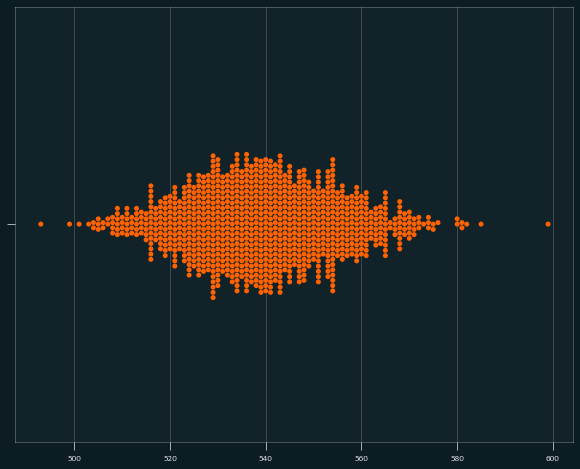

In [90]:
plt.figure(figsize=(10,8))
std=np.sqrt(2*np.pi)
x=np.random.choice([0,1],(1000,1000),p=[0.46,0.54]).sum(axis=0)
# draw_norm_err(0,1,err,-3,3,False)
sns.swarmplot(x)
plt.savefig('femmes.png')

In [91]:
def error_p(p,n=1000,Za=1.96) -> float:
    return np.sqrt(p*(1-p)/n)*Za
print(error_p(0.37,144,1.96))

def margin_p(p,n=1000,Za=1.96) -> np.array:
    er=error_p(p,n,Za)
    return np.array([p-er,p+er])

def error_in_margin(p,n,variation,Za=1.96,double_margin=True):
    # Compute old values
    old_p=p-variation
    # Compute err
    err=error_p(p/100,n,Za)*100
    # Compute err old values
    old_err=error_p(old_p/100,n,Za)*100
    if double_margin:
        return (np.abs(variation)<=err+old_err) & variation!=0
    else:
        return (np.abs(variation)<=err) & variation!=0

def extract_in_margin(fav,defav,evol_fav,evol_defav,pop_size,double_margin=True):
    # Suppression des valeurs sans variation
    fav=fav[evol_fav!=0]
    defav=defav[evol_defav!=0]
    pop_size_fav=pop_size[evol_fav!=0]
    pop_size_defav=pop_size[evol_defav!=0]
    evol_fav=evol_fav[evol_fav!=0]
    evol_defav=evol_defav[evol_defav!=0]

    # Calcul des erreurs
    err_fav=error_p(fav/100,pop_size_fav)*100
    err_defav=error_p(defav/100,pop_size_defav)*100

    # Calcul des anciennes valeurs
    old_fav=fav-evol_fav
    old_defav=defav-evol_defav
    # Calcul des erreurs anciennes valeurs
    err_old_fav=error_p(old_fav/100,pop_size_fav)*100
    err_old_defav=error_p(old_defav/100,pop_size_defav)*100
    if double_margin:
        total_fav_in_margin=np.sum(err_fav+err_old_fav>=np.abs(evol_fav))
        total_defav_in_margin=np.sum(err_defav+err_old_defav>=np.abs(evol_defav))
    else:
        total_fav_in_margin=np.sum(err_fav>=np.abs(evol_fav))
        total_defav_in_margin=np.sum(err_defav>=np.abs(evol_defav))
    total_in_margin=total_fav_in_margin+total_defav_in_margin
    total_lines=len(fav)+len(defav)

    return (total_in_margin,total_lines)

0.0788580370032123


# Load all dataframes



## Load method

In [92]:
def load_data(filepath):
    filenames=[f.rstrip('.p') for f in os.listdir(filepath)]
    df=pd.read_pickle("{}/{}.p".format(filepath,filenames[0]))
    all_data=pd.DataFrame(columns=df.columns)
    all_data.Base=all_data.Base.astype(int)
    for fn in filenames:
        df=pd.read_pickle("{}/{}.p".format(filepath,fn))
        if df.Base.dtype==object:
            df.Base=df.Base.astype(int)
        if 'Date' not in df.columns:
            df['Date']=fn
        all_data=pd.concat([all_data,df],ignore_index=True)
        in_margin,nb_lines=extract_in_margin(df['ST Favorable'],df['ST Défavorable'],df['Evolution ST Favorable'],df['Evolution ST Défavorable'],df.Base)
    all_data.Date=all_data.Date.astype('datetime64')
    return all_data

def load_data_perso(filepath):
    filenames=[f.rstrip('.p') for f in os.listdir(filepath)]
    df=pd.read_pickle("{}/{}.p".format(filepath,filenames[0]))
    all_data=pd.DataFrame(columns=df.columns)
    all_data.Base=all_data.Base.astype(int)
    for fn in filenames:
        df=pd.read_pickle("{}/{}.p".format(filepath,fn))
        if df.Base.dtype==object:
            df.Base=df.Base.astype(int)
        all_data=pd.concat([all_data,df],ignore_index=True)
    all_data.rename(columns={'Opinion positive':'ST Favorable'},inplace=True)
    all_data['ST Favorable']=all_data['ST Favorable'].astype(float)
    all_data.Date=all_data.Date.astype('datetime64')
    return all_data


## Load Ipsos


In [93]:
ipsos=load_data('ipsos/data')

D:\Programmes\Python3\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
D:\Programmes\Python3\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
D:\Programmes\Python3\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
D:\Programmes\Python3\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
D:\Programmes\Python3\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
D:\Programmes\Python3\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)

In [94]:
ipsos.head()

Nom Categorie       Groupe   Base  Très favorable  \
0  Edouard PHILIPPE  ENSEMBLE     ENSEMBLE  971.0             1.8   
1  Edouard PHILIPPE      Sexe        Homme  462.0             1.5   
2  Edouard PHILIPPE      Sexe        Femme  509.0             2.1   
3  Edouard PHILIPPE       Age  18 à 24 ans  103.0             2.0   
4  Edouard PHILIPPE       Age  25 à 34 ans  154.0             1.9   

   Plutôt favorable  ST Favorable  Plutôt défavorable  Très défavorable  \
0              19.9          21.7                32.9              39.7   
1              20.7          22.2                34.9              39.4   
2              19.2          21.3                31.2              39.9   
3              24.7          26.7                33.2              27.9   
4              11.1          13.0                33.8              43.6   

   ST Défavorable   Nsp  Evolution ST Favorable  Evolution ST Défavorable  \
0            72.6   5.7                    -5.0                       7.0   
1            74.3   3.5                    -9.6                       9.3   
2            71.1   7.6                    -0.9                       4.9   
3            61.1  12.2                     4.2                       1.1   
4            77.4   9.6                   -10.5                      15.4   

        Date  
0 2018-12-08  
1 2018-12-08  
2 2018-12-08  
3 2018-12-08  
4 2018-12-08

## Load Ifop


In [95]:
ifop=load_data('ifop/data')
ifop.head()

Nom Categorie    Groupe    Base  Très favorable  \
0   Emmanuel MACRON  ENSEMBLE  ENSEMBLE  1928.0             5.0   
1  Edouard PHILIPPE  ENSEMBLE  ENSEMBLE  1928.0             4.0   
2   Emmanuel MACRON  ENSEMBLE  ENSEMBLE  1891.0             5.0   
3  Edouard PHILIPPE  ENSEMBLE  ENSEMBLE  1891.0             3.0   
4   Emmanuel MACRON  ENSEMBLE  ENSEMBLE  1929.0             4.0   

   Plutôt favorable  ST Favorable  Plutôt défavorable  Très défavorable  \
0              22.0          27.0                32.0              40.0   
1              26.0          30.0                36.0              31.0   
2              23.0          28.0                34.0              37.0   
3              28.0          31.0                36.0              30.0   
4              25.0          29.0                36.0              33.0   

   ST Défavorable  Nsp  Evolution ST Favorable  Evolution ST Défavorable  \
0            72.0  1.0                     4.0                      -4.0   
1            67.0  3.0                    -1.0                       1.0   
2            71.0  1.0                     1.0                      -1.0   
3            66.0  3.0                     1.0                      -1.0   
4            69.0  2.0                     1.0                      -2.0   

        Date  
0 2019-01-19  
1 2019-01-19  
2 2019-02-16  
3 2019-02-16  
4 2019-03-23

## Load Ifop personalités

In [96]:
ifop_pers=load_data_perso('ifop/data_perso')
ifop_pers.head()

Nom    Base       Date  ST Favorable
0     Nicolas HULOT  1008.0 2020-01-11          72.0
1     Martine AUBRY  1008.0 2020-01-11          45.0
2   Nicolas SARKOZY  1008.0 2020-01-11          44.0
3  Edouard PHILIPPE  1008.0 2020-01-11          44.0
4    Ségolène ROYAL  1008.0 2020-01-11          44.0

# Comparaison des résultats des instituts de sondages 
## Calcul des erreurs théoriques


In [97]:
def compute_error(df,col):
    return error_p(df[col]/100,df.Base)*100

### Ajout des erreurs sur les mesures

In [98]:
ipsos['Erreur ST Fav']=compute_error(ipsos,'ST Favorable')
ipsos['Erreur ST Defav']=compute_error(ipsos,'ST Défavorable')
ipsos['Erreur PDefav']=compute_error(ipsos,'Plutôt défavorable')
ipsos['Erreur TDefav']=compute_error(ipsos,'Très défavorable')
ipsos['Erreur Nsp']=compute_error(ipsos,'Nsp')
ifop['Erreur ST Fav']=compute_error(ifop,'ST Favorable')
ifop['Erreur ST Defav']=compute_error(ifop,'ST Défavorable')
ifop['Erreur Nsp']=compute_error(ifop,'Nsp')
ifop_pers['Erreur ST Fav']=compute_error(ifop_pers,'ST Favorable')

# Différence de popularité du président et des premiers ministres

Les jeux de données IFOP contiennent très peu de personnes (président et premiers ministres)

In [99]:
noms_en_commun=[x for x in ifop.Nom.unique() if x in ipsos.Nom.unique()]

In [100]:
def plot_with_error(df1,df2,liste_noms,col,err_col,labels=['df1','df2']):
    for nom in liste_noms:
        plt.figure(figsize=(10,8))
        data=df1[df1.Nom==nom]
        sns.lineplot(x='Date',y=col,data=data)
        plt.fill_between(x=data.Date,\
            y1=data[col]-data[err_col],\
            y2=data[col]+data[err_col],\
                alpha=0.25)
        data=df2[(df2.Nom==nom)]
        sns.lineplot(x='Date',y=col,data=data)
        plt.fill_between(x=data.Date,\
            y1=data[col]-data[err_col],\
            y2=data[col]+data[err_col],\
                alpha=0.25)
        plt.legend(labels=labels)
        plt.title(nom)
        
def plot_onedf_with_error(df1,liste_noms,col,err_col,labels=['df1','df2']):
    plt.figure(figsize=(10,8))
    for nom in liste_noms:
        data=df1[df1.Nom==nom]
        sns.lineplot(x='Date',y=col,data=data)
        plt.fill_between(x=data.Date,\
            y1=data[col]-data[err_col],\
            y2=data[col]+data[err_col],\
                alpha=0.25)
    plt.legend(labels=labels)

## Soutiens favorables

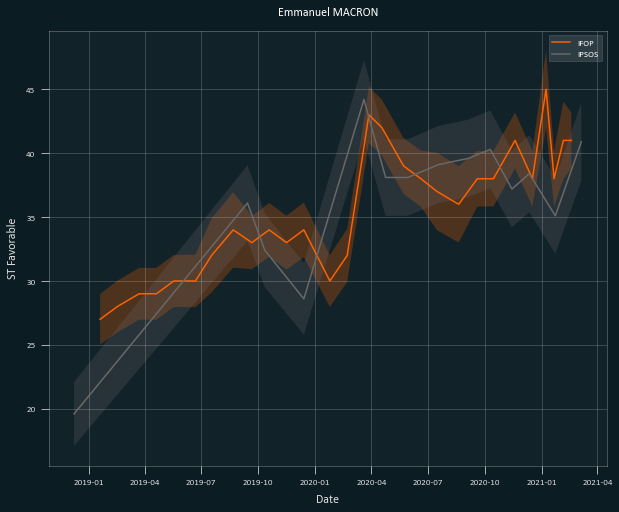

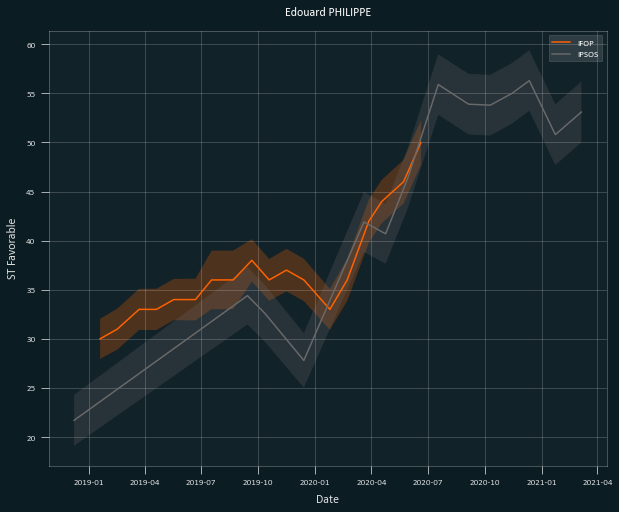

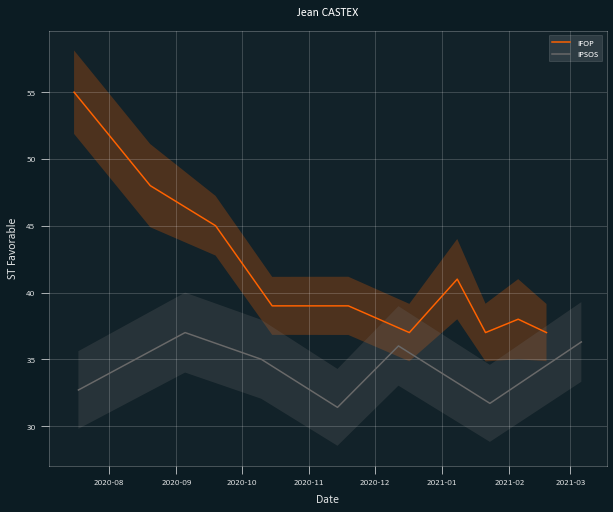

In [103]:
plot_with_error(ifop,ipsos[ipsos.Groupe=='ENSEMBLE'],noms_en_commun,'ST Favorable','Erreur ST Fav',['IFOP','IPSOS'])

## Soutien défavorables

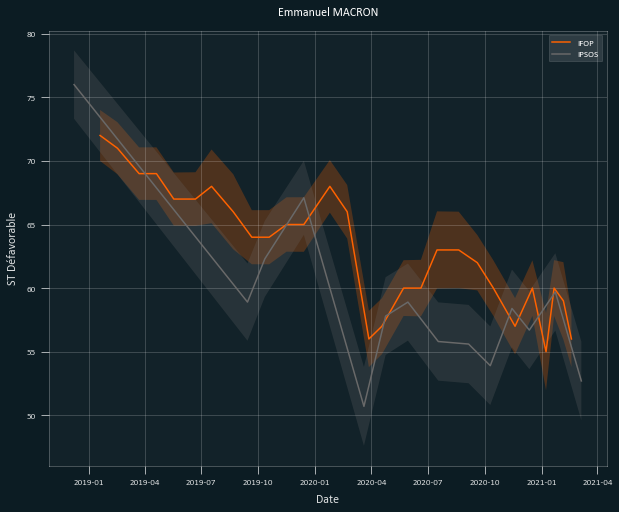

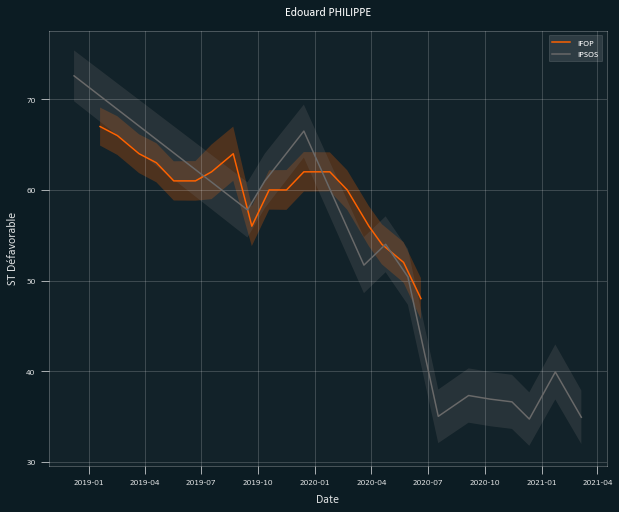

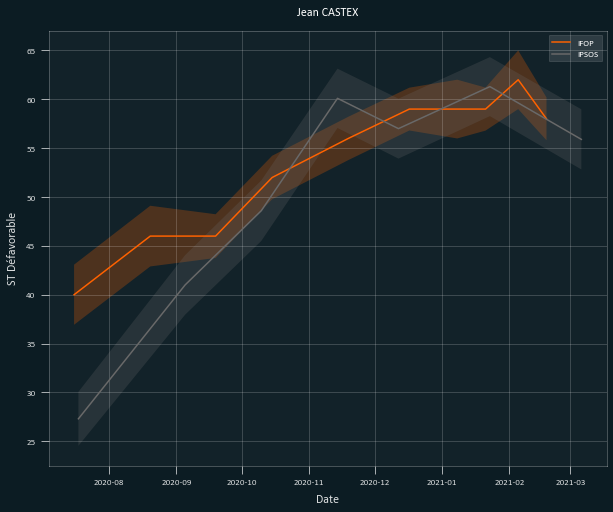

In [104]:
plot_with_error(ifop,ipsos[ipsos.Groupe=='ENSEMBLE'],noms_en_commun,'ST Défavorable','Erreur ST Defav',['IFOP','IPSOS'])


## Ne se prononcent pas

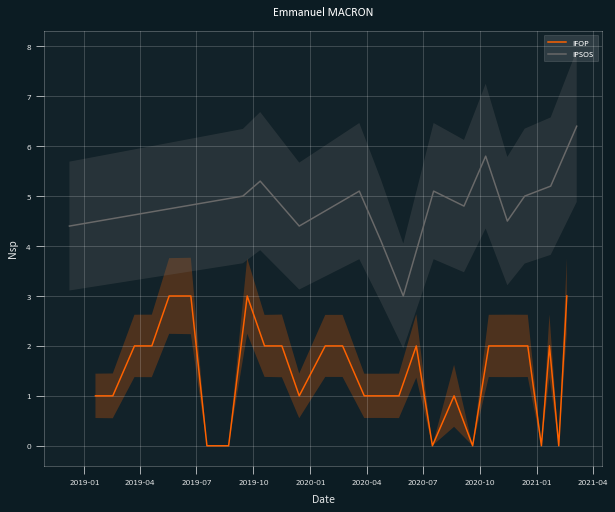

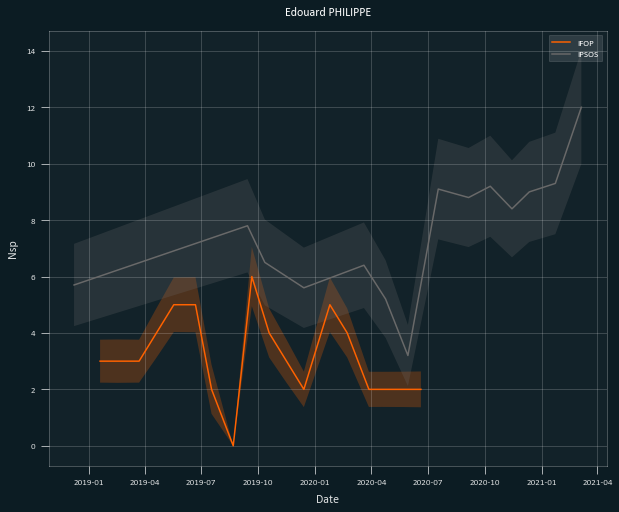

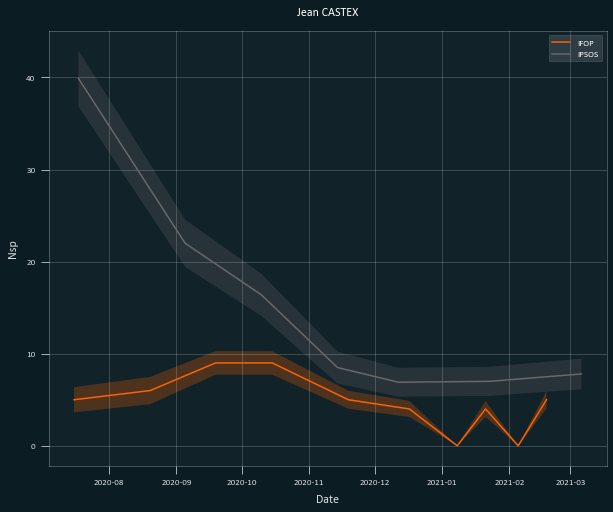

In [105]:
plot_with_error(ifop,ipsos[ipsos.Groupe=='ENSEMBLE'],noms_en_commun,'Nsp','Erreur Nsp',['IFOP','IPSOS'])

# Comparaison des scores par personnalité

On utilisera pour cela les mêmes données pour ipsos. Il faut noter la différence de question entre le deux sondages.
* IFOP demande l'opinion du sondés sur chaque personnalité. Le score est la somme des très bonnes opinons et des bonnes opinions.
* IPSOS demande l'opinion sur __l'action__ de la personnalité. Le système de score est la somme des soutiens très favorables et favorables.

Bien que les questions et les réponses sont différentes dans leurs formulations, beaucoup de personnalités non pas d'action particulière qui puisse être connue notoirement. Néanmoins on observe que le nombre de ne se prononce pas est relativement faible malgré cela.

In [106]:
noms_en_commun=[x for x in ifop_pers.Nom.unique() if x in ipsos.Nom.unique()]

ipykernel_launcher:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
ipykernel_launcher:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
ipykernel_launcher:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
ipykernel_launcher:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`mat

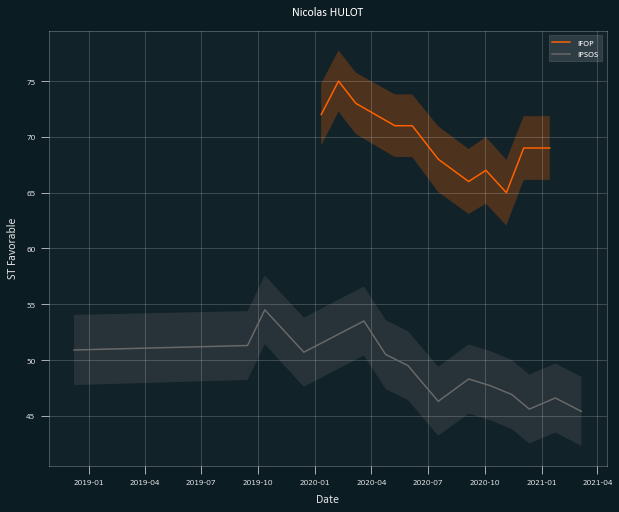

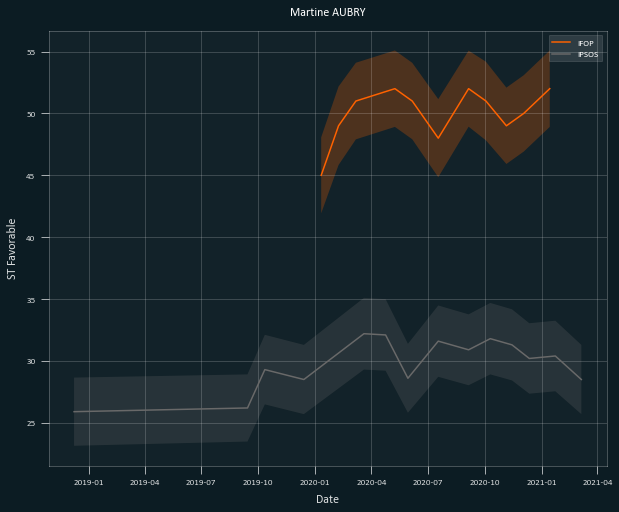

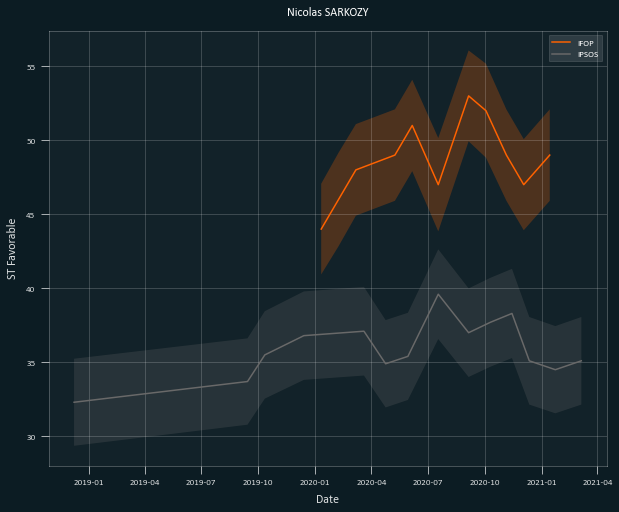

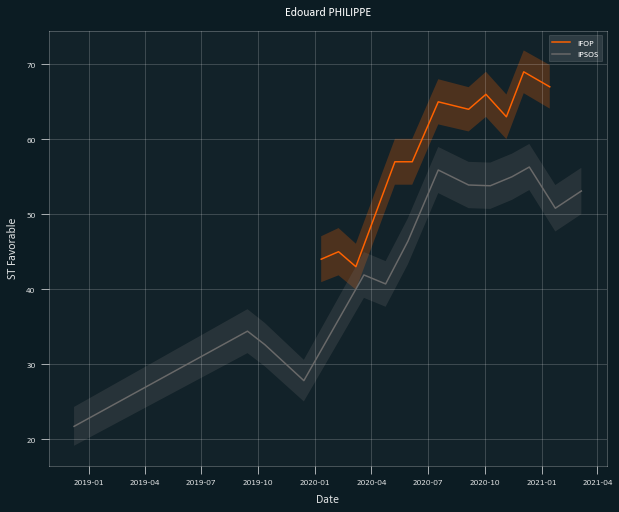

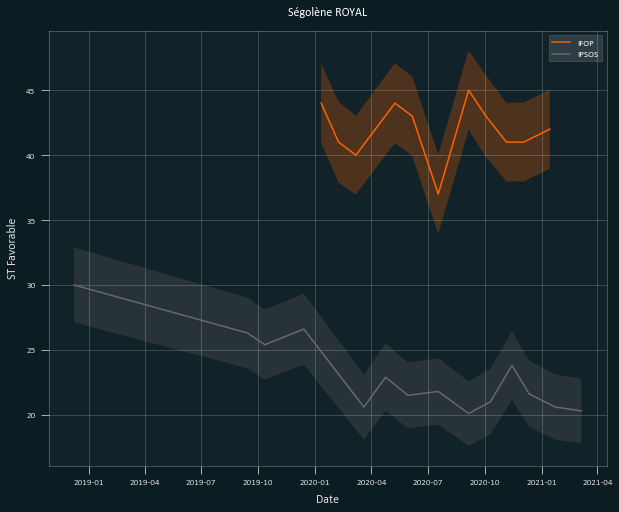

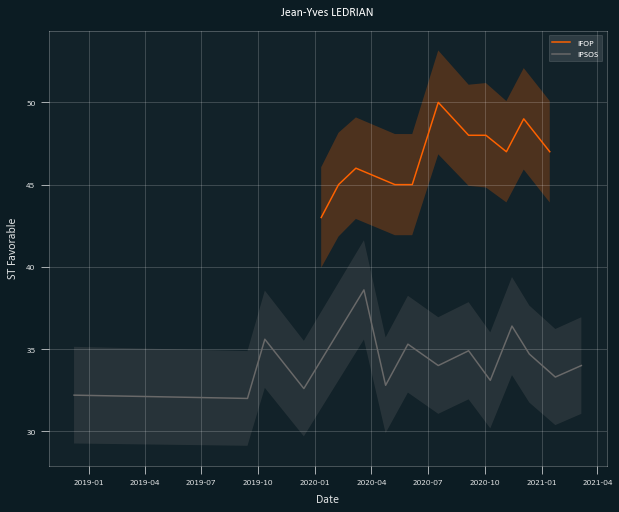

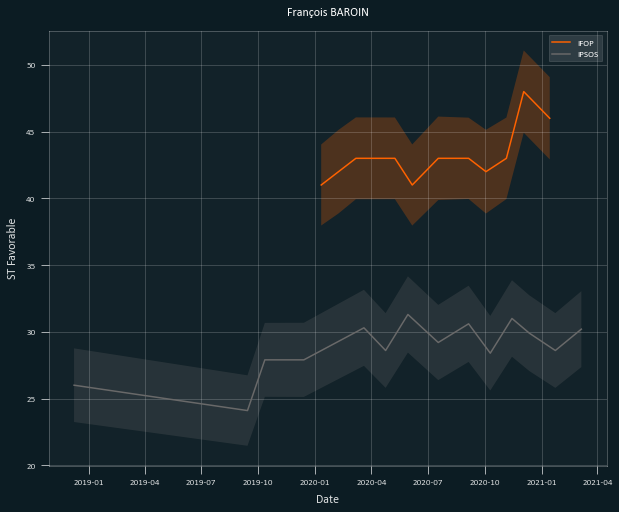

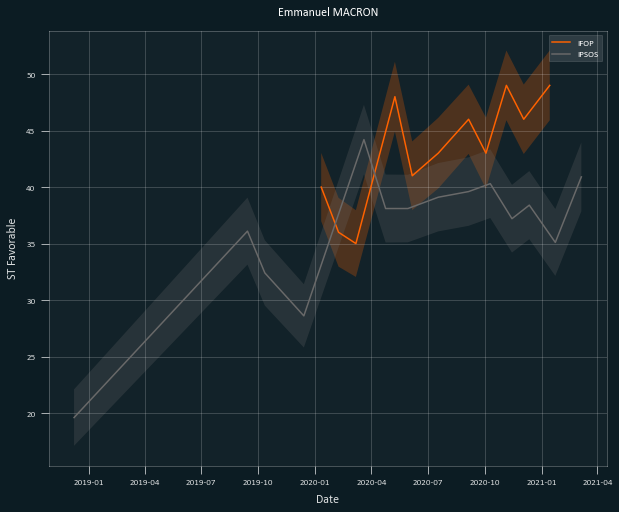

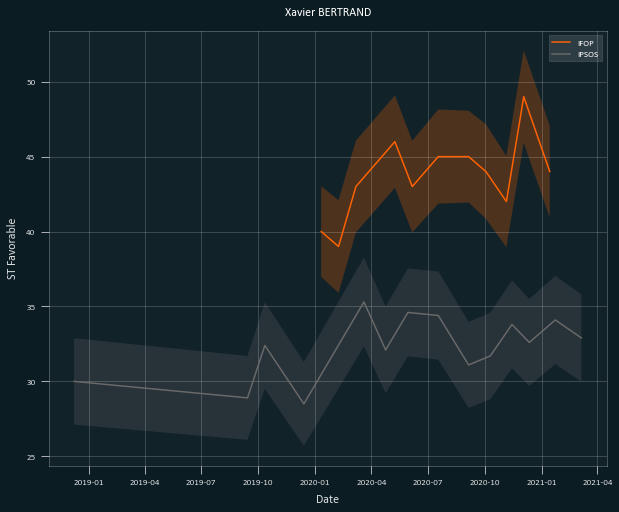

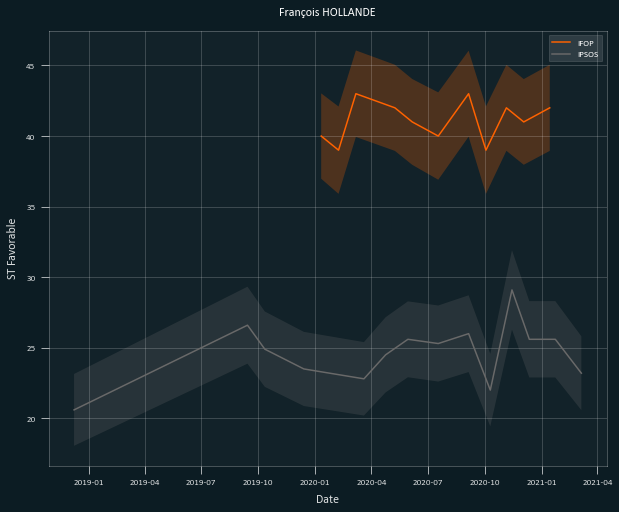

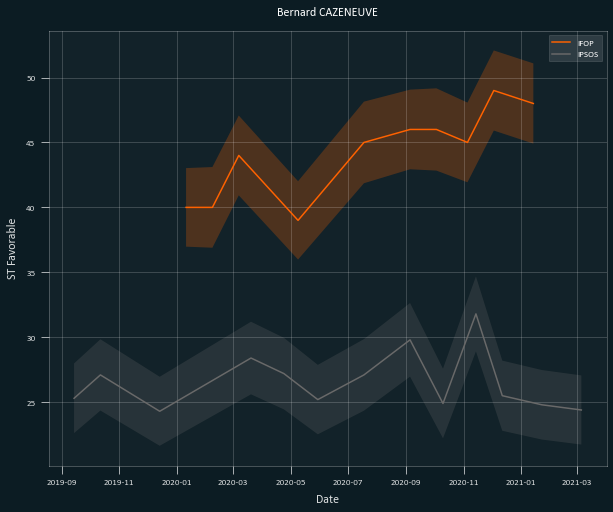

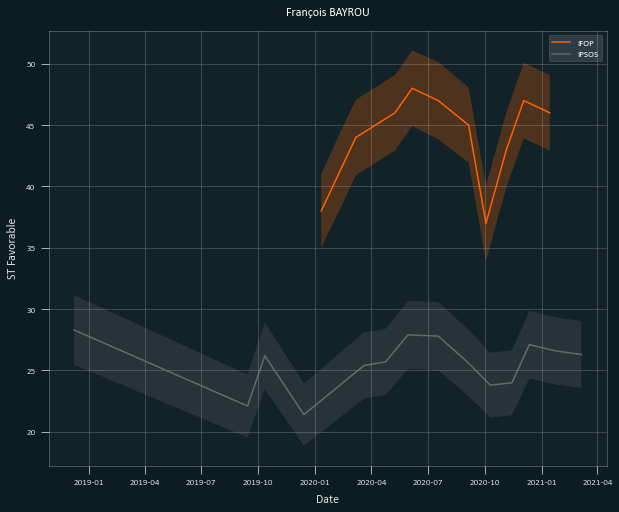

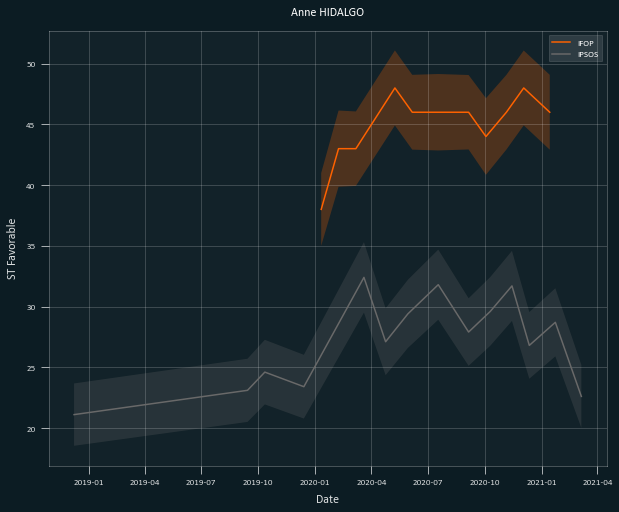

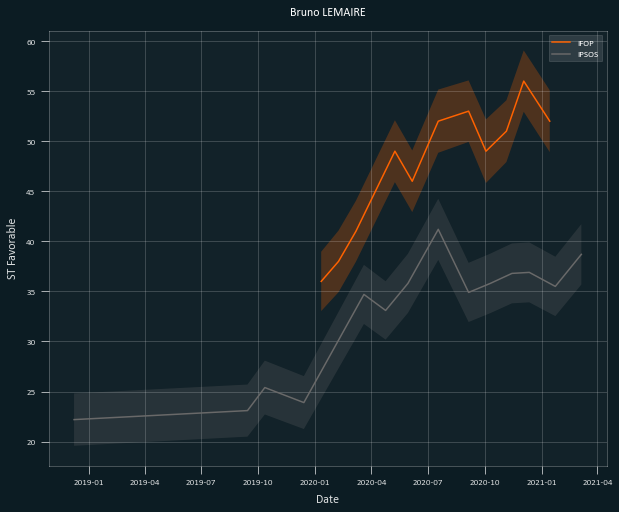

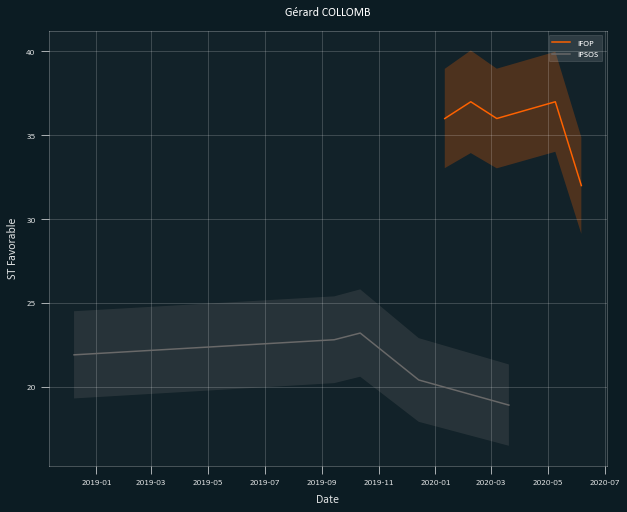

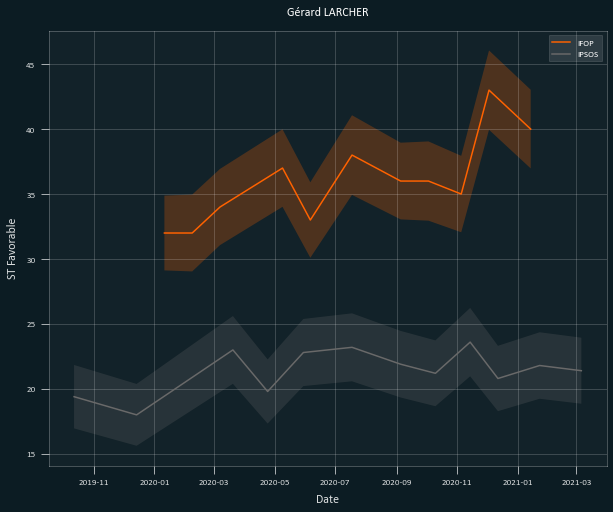

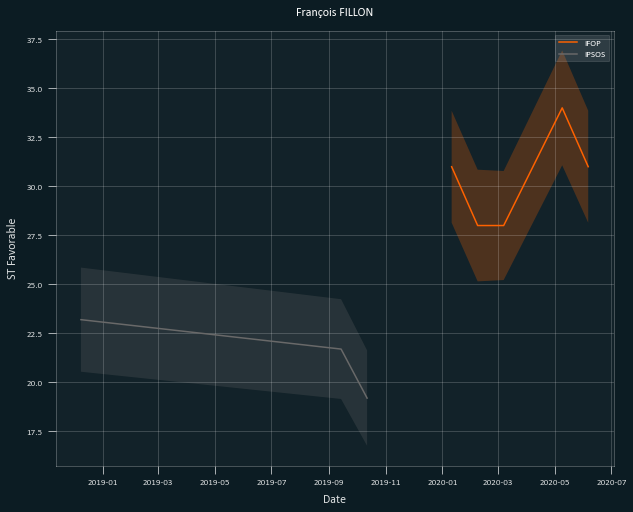

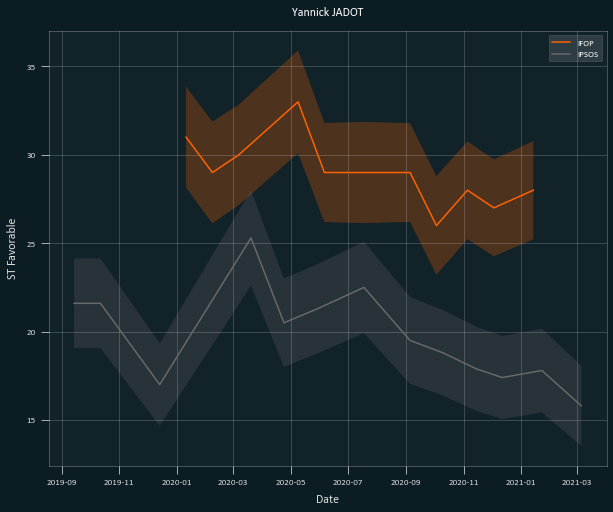

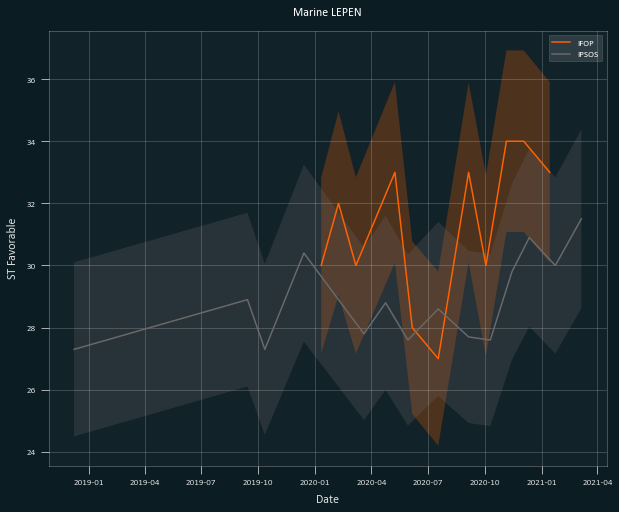

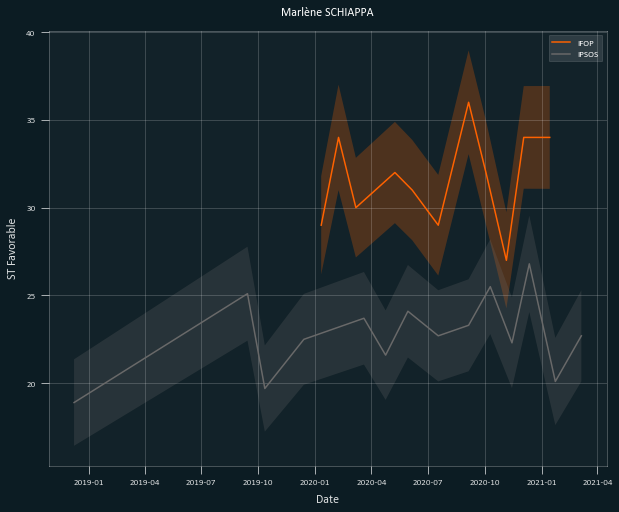

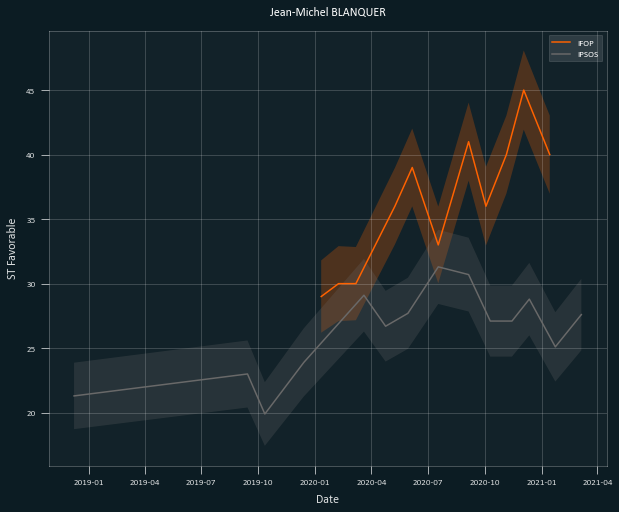

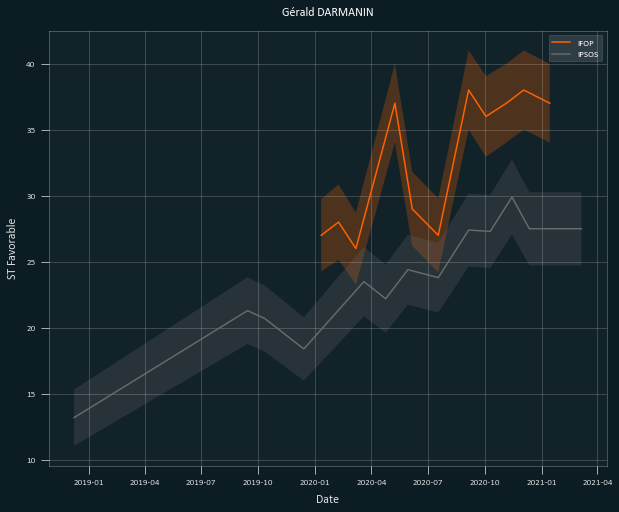

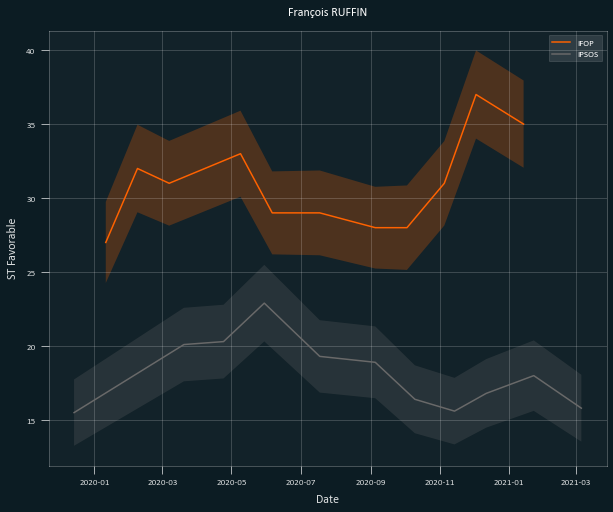

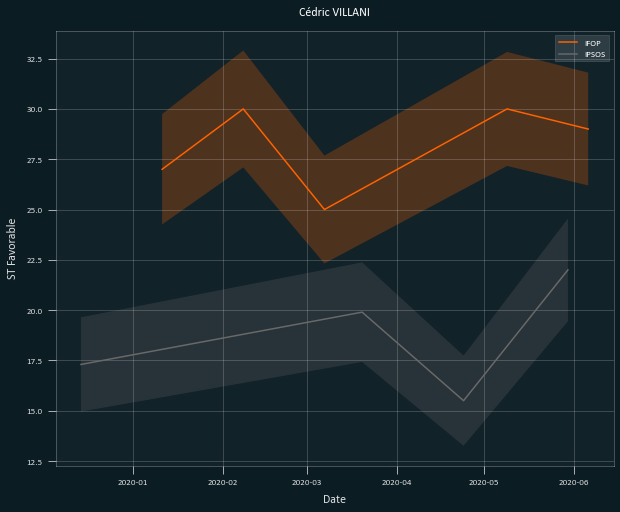

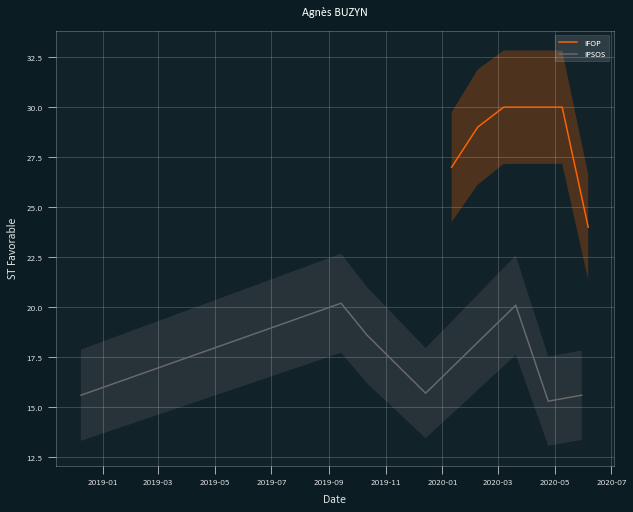

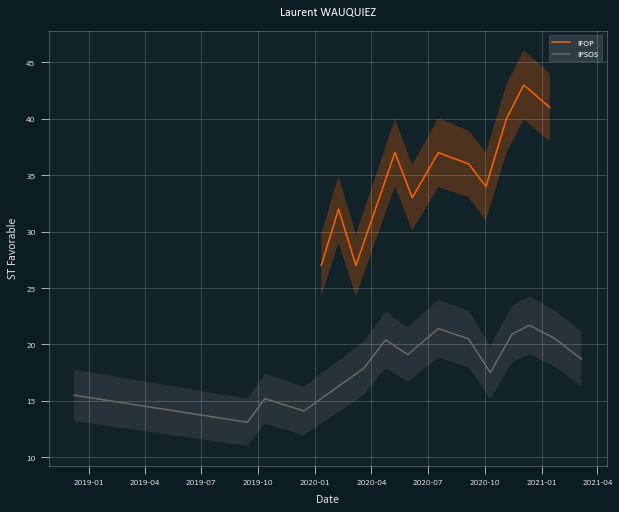

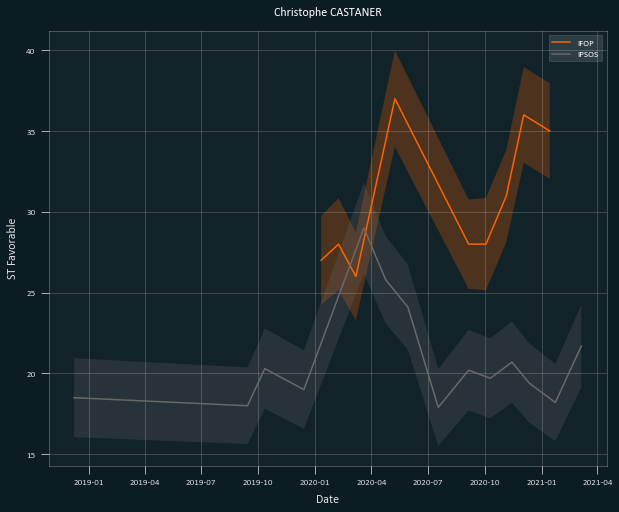

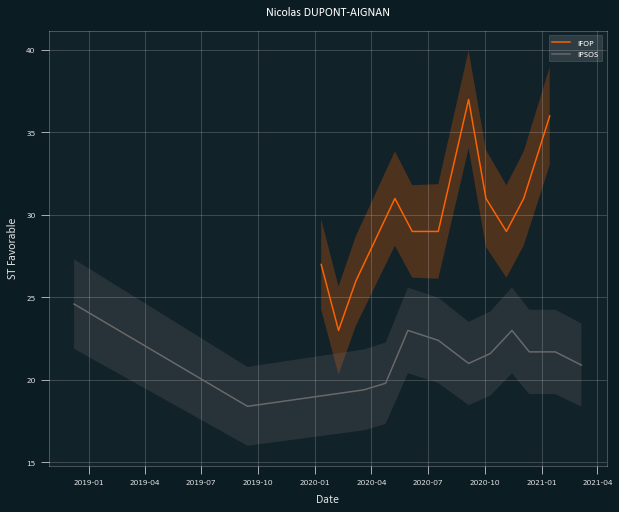

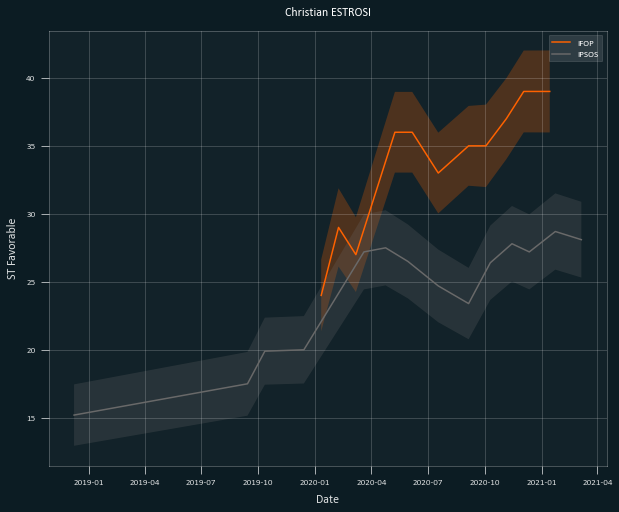

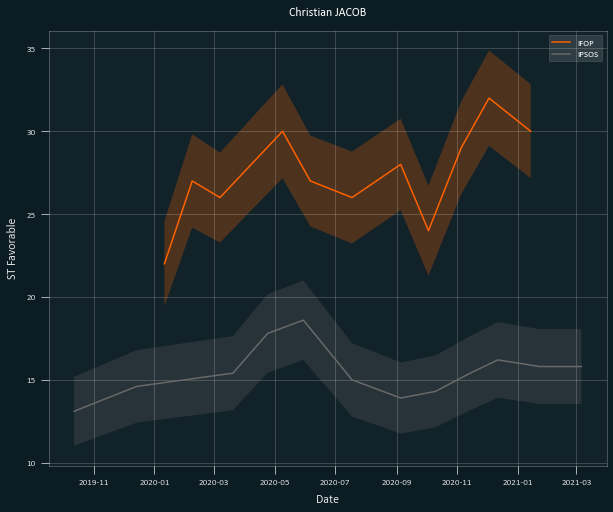

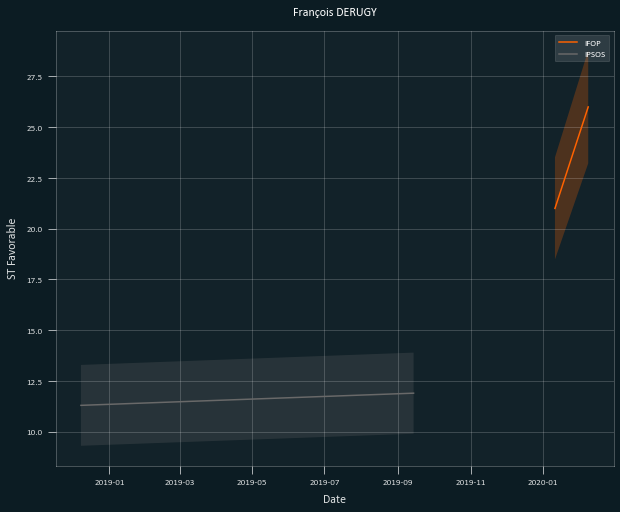

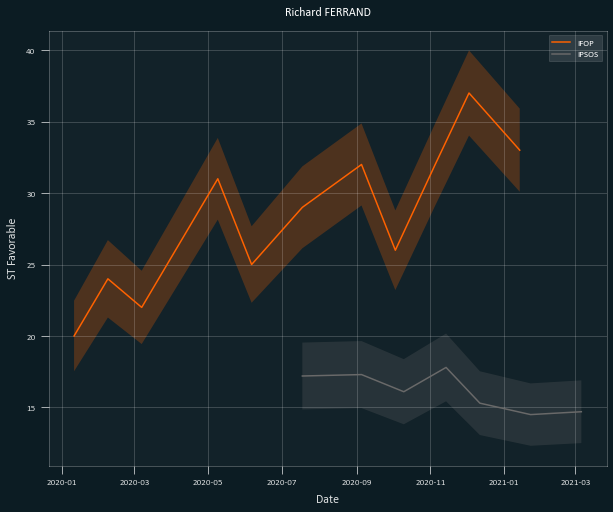

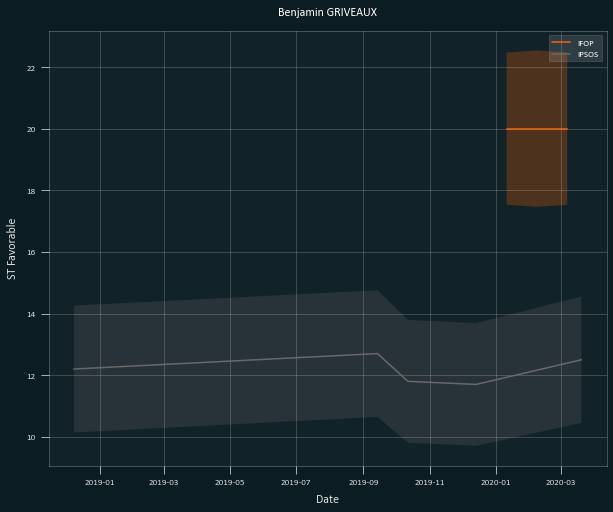

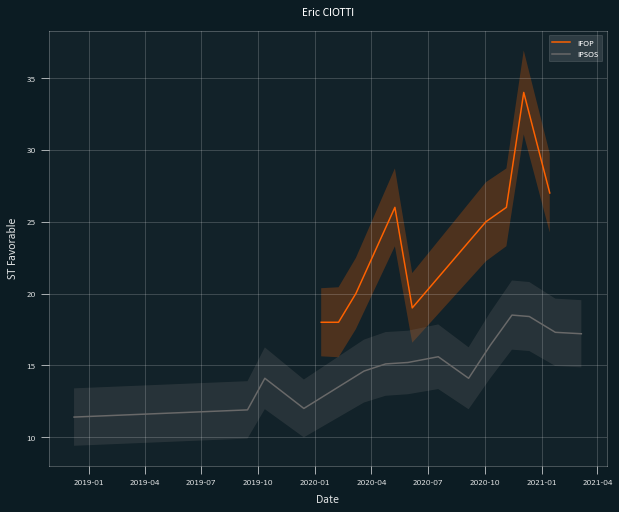

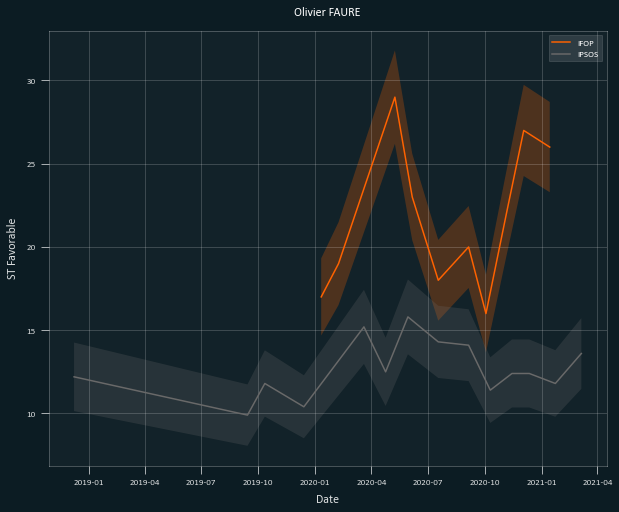

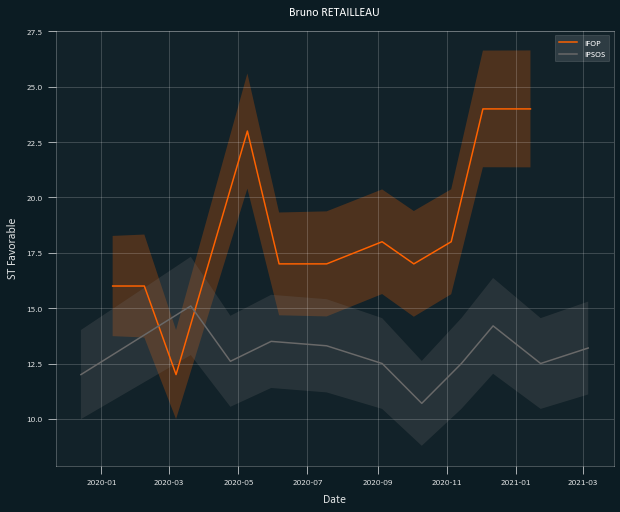

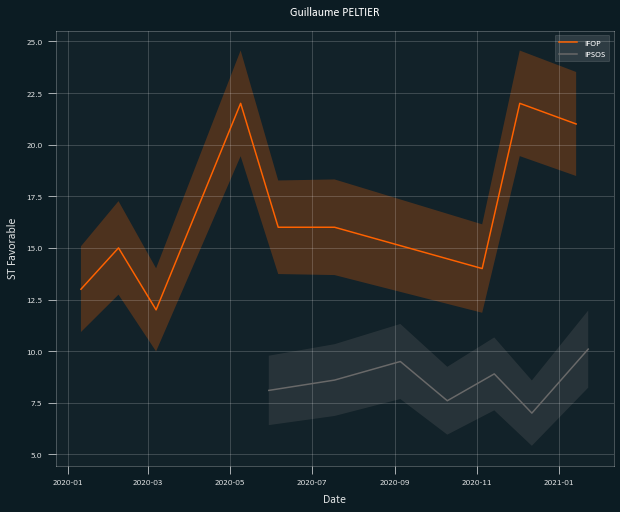

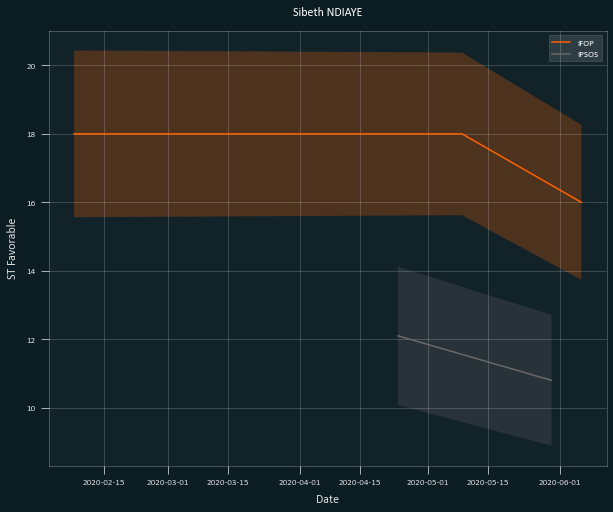

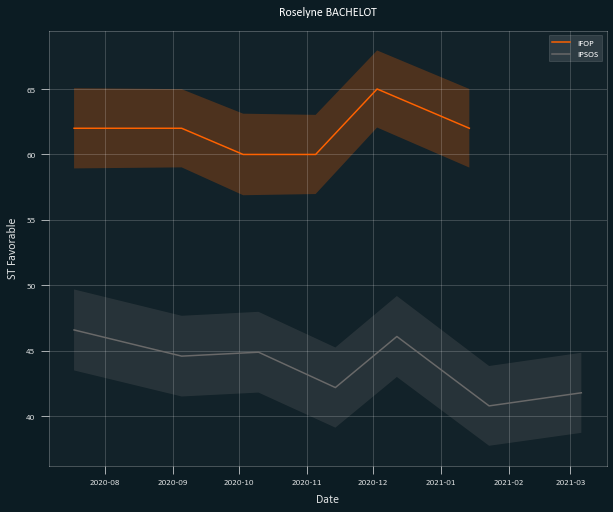

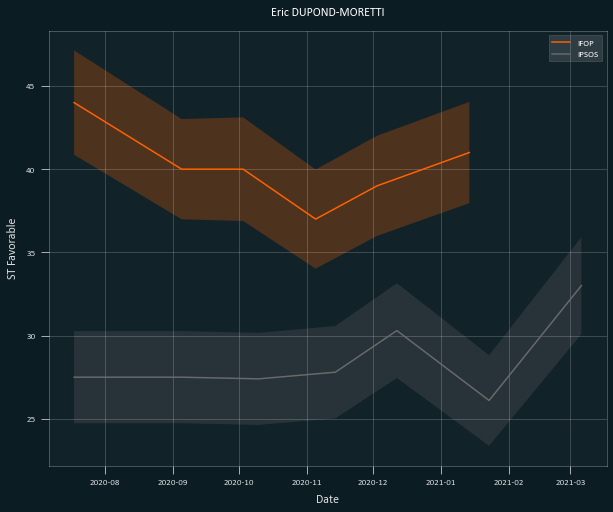

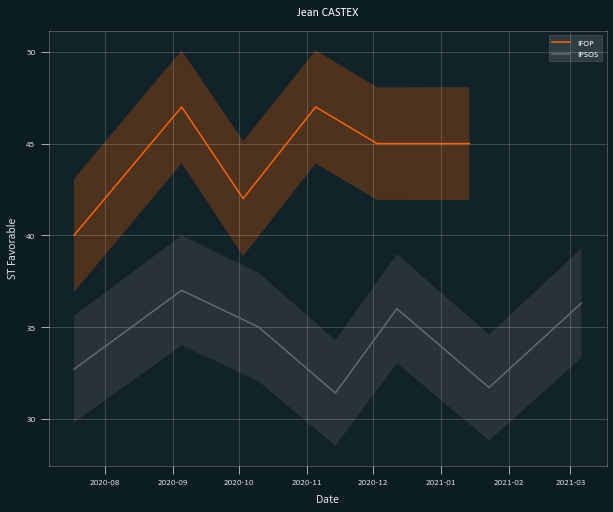

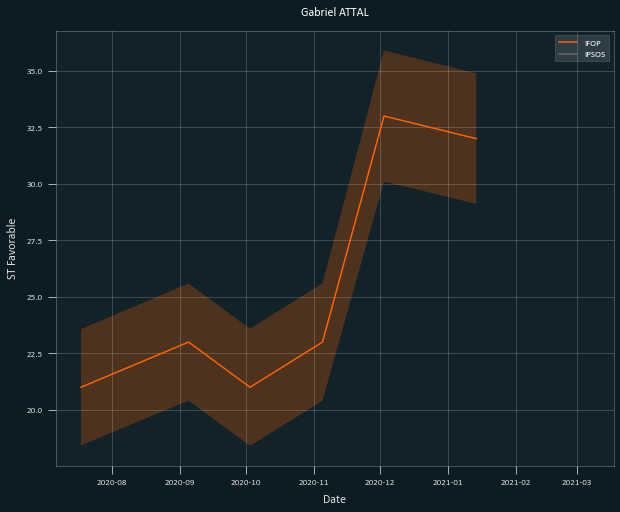

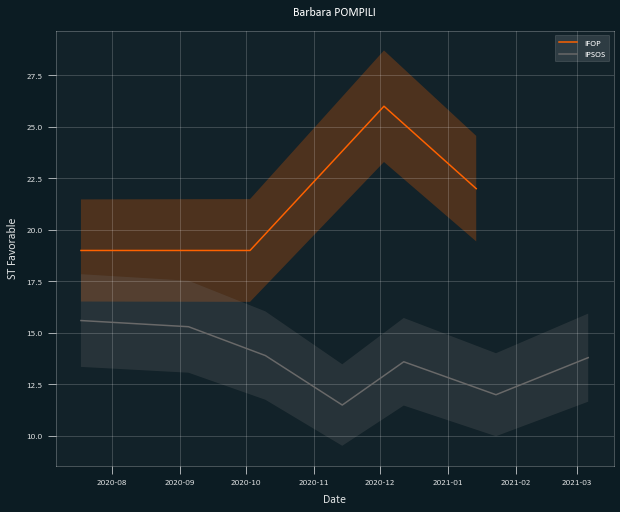

In [107]:
plot_with_error(ifop_pers,ipsos[ipsos.Groupe=='ENSEMBLE'],noms_en_commun,'ST Favorable','Erreur ST Fav',['IFOP','IPSOS'])

In [267]:
X=np.array([[12,8,25,50,14],
            [45,70,29,23,23],
            [21,5,15,3,12],
            [18,14,27,19,31],
            [4,3,4,5,20],
            [2,0,0,0,2],
            [2,0,0,0,0],
            [7,0,0,0,0],
            [27,1,3,1,10],
            [21,1,1,0,12],
            [18,1,1,2,1],
            [11,85,10,0,15],
            [0,0,2,0,1],
            [2,8,59,0,17],
            [2,1,14,1,7],
            [5,2,9,95,33],
            [2,1,1,1,2]
            ])
y=np.array([20,37,12,23,8,1,1,2,10,8,6,24,0.5,14,4,28,1.5])
lr=LinearRegression()
lr.fit(X,y)
lr.coef_*2550

array([604.530415  , 468.96897522, 320.55258272, 436.7723509 ,
       694.74638922])

In [277]:
X=np.array([[82,79,28,0,45],
            [18,21,72,100,55],
            [71,96,53,1,43],
            [29,4,47,99,57],
            [12,8,25,50,14],
            [45,70,29,23,23],
            [21,5,15,3,12],
            [18,14,27,19,31],
            [4,3,4,5,20],
            ])
y=np.array([49,51,53,47,20,37,12,23,8])
lr=LinearRegression()
lr.fit(X,y)
lr.coef_*2550

array([598.25053287, 412.00006853, 441.65438134, 409.17620798,
       698.4853805 ])

In [280]:
lr.singular_

array([145.24388516, 114.38969181,  31.17140133,  25.55497634,
        14.43949987])

In [246]:
lr=LinearRegression(positive=True,normalize=True)
lr.fit(X,y)
lr.coef_*1000

array([628.68513633, 371.93221872])